In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(palette='magma', n_colors=3)
sns.set_style("darkgrid")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from Resnet_adaptation import new_cnn_model

In [2]:
# set seeds
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
# Set compute device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


In [4]:
# get scalers, for CNN
training_set = np.load('./data/train.npz')

mean = round(training_set['x'][...,0].mean(), 2)
std = round(training_set['x'][...,0].std(), 2)

print("Mean ={}, Std = {}".format(mean, std))

Mean =4090.28, Std = 2164.09


In [5]:
# input data
train_x = np.load('./lr/linear_model_train_input.npy', allow_pickle = True)

# predictions
train_y = np.load('./lr/linear_model_train_output.npy', allow_pickle = True)

In [6]:
print("Max = {}, shape = {}".format(np.max(train_x), train_x.shape))
print("Max = {}, shape = {}".format(np.max(train_y), train_y.shape))

train_x = (train_x - mean)/ std
train_y = (train_y - mean)/ std

print("Max = {}, shape = {}".format(np.max(train_x), train_x.shape))
print("Max = {}, shape = {}".format(np.max(train_y), train_y.shape))

Max = 13442.0, shape = (9157, 12, 150)
Max = 14611.6357421875, shape = (9157, 12, 150)
Max = 4.321317505279355, shape = (9157, 12, 150)
Max = 4.861791610717773, shape = (9157, 12, 150)


In [7]:
# Define dataset
class TR_dataset(Dataset):
    def __init__(self, data_list, target_list):
        self.data_list = data_list
        self.target_list = target_list
        
    def __len__(self):
        assert len(self.target_list) == len(self.data_list)
        return len(self.data_list)

    def __getitem__(self, key):
        input_seq = self.data_list[key]
        targets = self.target_list[key]
        return [input_seq,targets]

In [8]:
BATCH_SIZE = 12

train_set = TR_dataset(train_x, train_y)

train_dataloader = torch.utils.data.DataLoader(dataset=train_set,
                                               batch_size=BATCH_SIZE,
                                               collate_fn=None,
                                               shuffle=False)

In [9]:
# Instantiate a ResNet adaptation model here
# See the model file for full model architecture
model = new_cnn_model.ResNet_Adaptation_model()
model = model.float().to(device)

In [10]:
print(model.parameters())

<generator object Module.parameters at 0x00000267BF7C0AC0>


In [11]:
# MSE
criterion = nn.MSELoss(reduction='mean')
#criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [12]:
def train(model, iterator, optimizer, criterion):
    
    model.train()
    epoch_loss = 0
    
    for i, (batch_input, batch_target) in enumerate(iterator):
        
        batch_input = batch_input.float().to(device)
        #print(batch_target.shape)
        batch_target = torch.flatten(batch_target.float(), start_dim=1).to(device)
        #print(batch_target.shape)
        optimizer.zero_grad()
        
        output = model(batch_input)
        
        mse_loss = criterion(output, batch_target)
        #RMSE, MSE not enough
        loss = torch.sqrt(mse_loss)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss+=loss.cpu().detach().numpy()
        #epoch_loss+=loss.item()
        
    # Average batch loss in an epoch
    return epoch_loss/len(iterator) 

In [13]:
# No need to apply softmax or measure accuracy 

# For now only 350, later change to 1500
num_epochs = 50
#num_epochs = 2

# Over total epochs
loss_epoch =[]
best_loss = float('inf')

for i in range(num_epochs):
    
    # Loss is averaged in an epoch. so this is average batch loss per epoch
    loss = train(model, train_dataloader, optimizer,criterion )
    print("Normalized RMSE Loss (Average Batch Loss)=", loss)
    
    if loss < best_loss:
        best_loss = loss
        # Save the entire model, not just state_dict
        torch.save(model, './lr/best_model_CNN.pt')
        
    loss_epoch.append(round(loss,2))
print("Best Loss = ", best_loss)

Normalized RMSE Loss (Average Batch Loss)= 0.6708338226323353
Normalized RMSE Loss (Average Batch Loss)= 0.6666515613881705
Normalized RMSE Loss (Average Batch Loss)= 0.6661470785971088
Normalized RMSE Loss (Average Batch Loss)= 0.6659474429815851
Normalized RMSE Loss (Average Batch Loss)= 0.6658026172696608
Normalized RMSE Loss (Average Batch Loss)= 0.6656472745366121
Normalized RMSE Loss (Average Batch Loss)= 0.6655428763771556
Normalized RMSE Loss (Average Batch Loss)= 0.6654561826695946
Normalized RMSE Loss (Average Batch Loss)= 0.6653359615833971
Normalized RMSE Loss (Average Batch Loss)= 0.6651998977542548
Normalized RMSE Loss (Average Batch Loss)= 0.6651020046928167
Normalized RMSE Loss (Average Batch Loss)= 0.6649486133097354
Normalized RMSE Loss (Average Batch Loss)= 0.6647200094467682
Normalized RMSE Loss (Average Batch Loss)= 0.6643473678390394
Normalized RMSE Loss (Average Batch Loss)= 0.6640787378187579
Normalized RMSE Loss (Average Batch Loss)= 0.6638289154824162
Normaliz

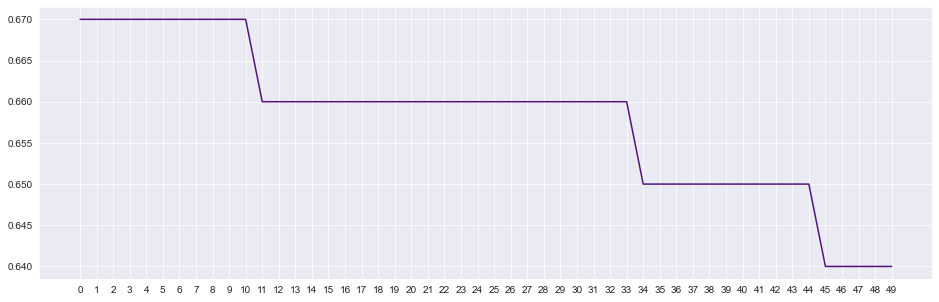

In [14]:
# Train loss curve
x = np.arange(num_epochs)
fig, ax = plt.subplots(figsize=(16,5))
ax.plot(x, loss_epoch)
ax.set_xticks(x);

In [15]:
# need to measure performance on the test set ?
# on the other side, performance was 1870

In [45]:
test_set = np.load('./data/test.npz')
test_x = np.squeeze(test_set['x'])
test_y = np.squeeze(test_set['y'])

print(test_x.shape)
print(test_y.shape)

# normalize before feeding to resnet

test_x = (test_x - mean)/ std
test_y = (test_y - mean)/ std

print(np.max(test_x))

(2616, 12, 150)
(2616, 12, 150)
3.4904832978295723


In [46]:
TEST_BATCH_SIZE = 1

test_set = TR_dataset(test_x, test_y)

test_dataloader = torch.utils.data.DataLoader(dataset=test_set,
                                               batch_size=TEST_BATCH_SIZE,
                                               collate_fn=None,
                                               shuffle=False)

In [47]:
trained_model = torch.load('./lr/best_model_CNN.pt')
trained_model.eval()
outputs = []

with torch.no_grad():
    for bi, (data, target) in enumerate(test_dataloader):
        
        data_batch, label_batch = data.float().to(device), target.float().to(device)
        
        output_batch = trained_model(data_batch)
        
        # add cpu() before detach if device changed to GPU
        output_batch_numpy = output_batch.cpu().detach().numpy().reshape(12,-1)
        
        #print(output_batch_numpy.shape)
        outputs.append(output_batch_numpy)
outputs = np.array(outputs)
print(outputs.shape)

np.save('./lr/resnet_test_output.npy', outputs)

(2616, 12, 150)


In [48]:
def get_metrics(pred, truth):
    
    # assert both have same lengths
    num_signals = len(pred)
    #print(num_signals)
    
    number_of_nodes = 150
    time_steps = 12

    rmse_collect = []
    rmse = 0.0
    
    for i in range(num_signals):
        rmse_signal = np.sum(np.square(pred[i]- truth[i]))
        
        # save this to true rmse first
        rmse+= rmse_signal
        
        # arrange to collect
        rmse_signal = np.sqrt(rmse_signal/(time_steps*number_of_nodes))
        
        # collect it
        rmse_collect.append(round(rmse_signal,2))
        

    rmse = np.sqrt(rmse/(num_signals*time_steps*number_of_nodes))
    #print(rmse)
    rmse_collect = np.array(rmse_collect)
    
    return rmse, rmse_collect

In [49]:
# load gts, check for norm
gts = np.squeeze(np.load('./data/test.npz', allow_pickle = True)['y'])
print(np.max(gts), gts.shape)

# load resnet preds and denormalize
f_preds = np.squeeze(np.load('./lr/resnet_test_output.npy', allow_pickle = True))
print("Max = {}, shape = {}".format(np.max(f_preds), f_preds.shape))

f_preds = (f_preds*std) + mean
print("Max = {}, shape = {}".format(np.max(f_preds), f_preds.shape))

11644.0 (2616, 12, 150)
Max = 5.560677528381348, shape = (2616, 12, 150)
Max = 16124.0869140625, shape = (2616, 12, 150)


In [50]:
rmse, collect = get_metrics(f_preds, gts )
print(rmse)

1971.4236516117278
